## **Fraud Cluster Detection in Python**

**Project Description**

A typical organization loses an estimated 5% of its yearly revenue to fraud. In this course, learn to fight fraud by using data. Apply supervised learning algorithms to detect fraudulent behavior based upon past fraud, and use unsupervised learning methods to discover new types of fraud activities. 

Fraudulent transactions are rare compared to the norm.  As such, learn to properly classify imbalanced datasets.

This notebook demonstrates how to implement fraud detection models. 

* You can download the data by clicking on the following link: https://assets.datacamp.com/production/repositories/2162/datasets/cc3a36b722c0806e4a7df2634e345975a0724958/chapter_1.zip

**Imports**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns

**Pandas Configuration Options**

In [5]:
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 300)
pd.set_option('display.expand_frame_repr', True)

**Data File Objects**

In [69]:
data = Path.cwd() / 'data'

ch3 = data / 'chapter_3'
banksim_file = ch3 / 'banksim.csv'
banksim_adj_file = ch3 / 'banksim_adj.csv'

# Introduction and preparing your data

Learn about the typical challenges associated with fraud detection. Learn how to resample data in a smart way, and tackle problems with imbalanced data.

## Introduction to fraud detection

* Types:
    * Insurance
    * Credit card
    * Identity theft
    * Money laundering
    * Tax evasion
    * Healthcare
    * Product warranty
* e-commerce businesses must continuously assess the legitimacy of client transactions
* Detecting fraud is challenging:
    * Uncommon; < 0.01% of transactions
    * Attempts are made to conceal fraud
    * Behavior evolves
    * Fraudulent activities perpetrated by networks - organized crime
* Fraud detection requires training an algorithm to identify concealed observations from any normal observations
* Fraud analytics teams:
    * Often use rules based systems, based on manually set thresholds and experience
    * Check the news
    * Receive external lists of fraudulent accounts and names
        * suspicious names or track an external hit list from police to reference check against the client base
    * Sometimes use machine learning algorithms to detect fraud or suspicious behavior
        * Existing sources can be used as inputs into the ML model
        * Verify the veracity of rules based labels

## Fraud detection algorithms in action

#### Rules Based Systems

* ![rules based](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/rules_based.JPG)
* Might block transactions from risky zip codes
* Block transactions from cards used too frequently (e.g. last 30 minutes)
* Can catch fraud, but also generates false alarms (false positive)
* Limitations:
    * Fixed threshold per rule and it's difficult to determine the threshold; they don't adapt over time
    * Limited to yes / no outcomes, whereas ML yields a probability
        * probability allows for fine-tuning the outcomes (i.e. rate of occurences of false positives and false negatives)
    * Fails to capture interaction between features
        * Ex. Size of the transaction only matters in combination to the frequency

#### ML Based Systems

* Adapt to the data, thus can change over time
* Uses all the data combined, rather than a threshold per feature
* Produces a probability, rather than a binary score
* Typically have better performance and can be combined with rules

# Fraud detection using unlabeled data

Use unsupervised learning techniques to detect fraud. Segment customers, use K-means clustering and other clustering algorithms to find suspicious occurrences in your data.

## Normal versus abnormal behavior

* Explore fraud detection without reliable data labels
* Unsupervised learning to detect suspicious behavior
* Abnormal behavior isn't necessarily fraudulent
* Challenging because it's difficult to validate

#### What's normal behavior?

* thoroughly describe the data:
    * plot histograms
    * check for outliers
    * investigate correlations
* Are there any known historic cases of fraud? What typifies those cases?
* Investigate whether the data is homogeneous, or whether different types of clients display different behavior
* Check patterns within subgroups of data: is your data homogeneous?
* Verify data points are the same type:
    * individuals
    * groups
    * companies
    * governmental organizations
* Do the data points differ on:
    * spending patterns
    * age
    * location
    * frequency
* For credit card fraud, location can be an indication of fraud
* This goes for e-commerce sites
    * where's the IP address located and where is the product ordered to ship?
* Create a separate model for each segment
* How to aggregate the many model results back into one final list

### Exploring the data

In the next exercises, you will be looking at bank **payment transaction data**. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, you have some client characteristics available such as age group and gender. Some of the transactions are labeled as fraud; you'll treat these labels as given and will use those to validate the results.

When using unsupervised learning techniques for fraud detection, you want to **distinguish normal from abnormal** (thus potentially fraudulent) behavior. As a fraud analyst to understand what is "normal", you need to have a good understanding of the data and its characteristics. Let's explore the data in this first exercise.

**Instructions 1/3**

* Obtain the shape of the dataframe `df` to inspect the size of our data and display the first rows to see which features are available.

In [70]:
banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [71]:
banksim_df.shape

(7200, 5)

In [72]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [73]:
banksim_adj_df.shape

(7189, 18)

In [74]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**Instructions 2/3**

* Group the data by transaction category and take the mean of the data.

In [75]:
banksim_df.groupby(['category']).mean()

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


**Instructions 3/3**

Based on these results, can you already say something about fraud in our data?

**Possible Answers**

* ~~No, I don't have enough information.~ 
* **Yes, the majority of fraud is observed in travel, leisure and sports related transactions.**

### Customer segmentation

In this exercise you're going to check whether there are any **obvious patterns** for the clients in this data, thus whether you need to segment your data into groups, or whether the data is rather homogenous.

You unfortunately don't have a lot client information available; you can't for example distinguish between the wealth levels of different clients. However, there is data on **age ** available, so let's see whether there is any significant difference between behavior of age groups.

**Instructions 1/3**

* Group the dataframe `df` by the category `age` and get the means for each age group.

In [76]:
banksim_df.groupby(['age']).mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


**Instructions 2/3**

* Count the values of each age group.

In [77]:
banksim_df.age.value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

**Instructions 3/3**

Based on the results you see, does it make sense to divide your data into age segments before running a fraud detection algorithm?

**Possible Answers**

* **No, the age groups who are the largest are relatively similar.**
* ~~Yes, the age group "0" is very different and I would split that one out.~~

**The average amount spent as well as fraud occurrence is rather similar across groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.**

### Using statistics to define normal behavior

In the previous exercises we saw that fraud is **more prevalent in certain transaction categories**, but that there is no obvious way to segment our data into for example age groups. This time, let's investigate the **average amounts spent** in normal transactions versus fraud transactions. This gives you an idea of how fraudulent transactions **differ structurally** from normal transactions.

**Instructions**

* Create two new dataframes from fraud and non-fraud observations. Locate the data in `df` with `.loc` and assign the condition "where fraud is 1" and "where fraud is 0" for creation of the new dataframes.
* Plot the `amount` column of the newly created dataframes in the histogram plot functions and assign the labels `fraud` and `nonfraud` respectively to the plots.

In [78]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

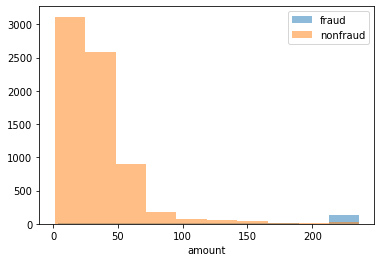

In [79]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

**As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal observations. This is good news, as it helps us later in detecting fraud from non-fraud. In the next chapter you're going to implement a clustering model to distinguish between normal and abnormal transactions, when the fraud labels are no longer available.**

## Clustering methods to detect fraud

#### K-means clustering

![k-means](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/k-means.JPG)

* The objective of any clustering model is to detect patterns in the data
* More specifically, to group the data into distinct clusters made of data points that are very similar to each other, but distinct from the points in the other clusters.
* **The objective of k-means is to minimize the sum of all distances between the data samples and their associated cluster centroids**
    * The score is the inverse of that minimization, so the score should be close to 0.
* **Using the distance to cluster centroids**
    * Training samples are shown as dots and cluster centroids are shown as crosses
    * Attempt to cluster the data in image A
        * Start by putting in an initial guess for two cluster centroids, as in B
        * Predefine the number of clusters at the start
        * Then calculate the distances of each sample in the data to the closest centroid
        * Figure C shows the data split into the two clusters
        * Based on the initial clusters, the location of the centroids can be redefined (fig D) to minimize the sum of all distances in the two clusters.
        * Repeat the step of reassigning points that are nearest to the centroid (fig E) until it converges to the point where no sample gets reassigned to another cluster (fig F)
        * ![clustering](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clustering.JPG)

#### K-means clustering in Python

* It's of utmost importance to scale the data before doing K-means clustering, or any algorithm that uses distances
* Without scaling, features on a larger scale will weight more heavily in the algorithm.  All features should weigh equally at the initial stage
* fix `random_state` so models can be compared

In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Transform and scale your data
X = np.array(df).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define the k-means model and fit to the data
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

#### The right amount of clusters

* The drawback of K-means clustering is the need to assign the number of clusters beforehand
* There are multiple ways to check what the right number of clusters should be
    * Silhouette method
    * Elbow curve
* By running a k-means model on clusters varying from 1 to 10 and generate an **elbow curve** by saving the scores for each model under "score".
* Plot the scores against the number of clusters


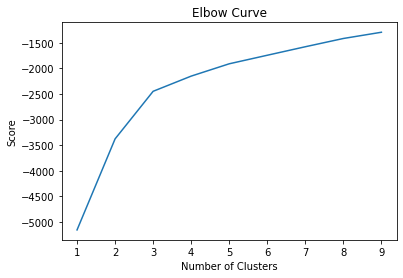

In [81]:
clust = range(1, 10) 
kmeans = [KMeans(n_clusters=i) for i in clust]

score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Scaling the data

For ML algorithms using distance based metrics, it is **crucial to always scale your data**, as features using different scales will distort your results. K-means uses the Euclidean distance to assess distance to cluster centroids, therefore you first need to scale your data before continuing to implement the algorithm. Let's do that first.

Available is the dataframe `df` from the previous exercise, with some minor data preparation done so it is ready for you to use with `sklearn`. The fraud labels are separately stored under labels, you can use those to check the results later.

**Instructions**

* Import the ``MinMaxScaler``.
* Transform your dataframe `df` into a numpy array `X` by taking only the values of `df` and make sure you have all `float` values.
* Apply the defined scaler onto `X` to obtain scaled values of `X_scaled` to force all your features to a 0-1 scale.

In [82]:
labels = banksim_adj_df.fraud

In [83]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [84]:
# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(np.float)

In [85]:
X.shape

(7189, 17)

In [86]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### K-mean clustering

A very commonly used clustering algorithm is **K-means clustering**. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when you are working with transaction data. **MiniBatch K-means** is an **efficient way** to implement K-means on a large dataset, which you will use in this exercise.

The scaled data from the previous exercise, `X_scaled` is available. Let's give it a try.

**Instructions**

* Import `MiniBatchKMeans` from `sklearn`.
* Initialize the minibatch kmeans model with 8 clusters.
* Fit the model to your scaled data.

In [87]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

**You have now fitted your MiniBatch K-means model to the data. In the upcoming exercises you're going to explore whether this model is any good at flagging fraud. But before doing that, you still need to figure our what the right number of clusters to use is. Let's do that in the next exercise.**

### Elbow method

In the previous exercise you've implemented MiniBatch K-means with 8 clusters, without actually checking what the right amount of clusters should be. For our first fraud detection approach, it is important to **get the number of clusters right**, especially when you want to use the outliers of those clusters as fraud predictions. To decide which amount of clusters you're going to use, let's apply the **Elbow method** and see what the optimal number of clusters should be based on this method.

`X_scaled` is again available for you to use and `MiniBatchKMeans` has been imported from `sklearn`.

**Instructions**

* Define the range to be between 1 and 10 clusters.
* Run MiniBatch K-means on all the clusters in the range using list comprehension.
* Fit each model on the scaled data and obtain the scores from the scaled data.
* Plot the cluster numbers and their respective scores.

In [88]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

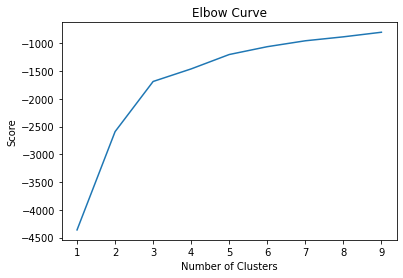

In [89]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Now you can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud**

## Assigning fraud vs. non-fraud

* ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_1.JPG)
* Take the outliers of each cluster, and flag those as fraud.
* ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_2.JPG)
1. Collect and store the cluster centroids in memory
    * Starting point to decide what's normal and not
1. Calculate the distance of each point in the dataset, to their own cluster centroid
* ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_3.JPG)
    * Euclidean distance is depicted by the circles in this case
    * Define a cut-off point for the distances to define what's an outlier
        * Done based on the distributions of the distances collected
        * i.e. everything with a distance larger than the top 95th percentile, should be considered an outlier
        * the tail of the distribution of distances
        * anything outside the yellow circles is an outlier
        * ![clusters](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/clusters_4.JPG)
        * these are definitely outliers and can be described as abnormal or suspicious
            * doesn't necessarily mean they are fraudulent

#### Flagging Fraud Based on Distance to Centroid

```python
# Run the kmeans model on scaled data
kmeans = KMeans(n_clusters=6, random_state=42,n_jobs=-1).fit(X_scaled)

# Get the cluster number for each datapoint
X_clusters = kmeans.predict(X_scaled)

# Save the cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 93)] = 1
km_y_pred[dist<np.percentile(dist, 93)] = 0
```

* `np.linalg.norm`: returns the vector norm, the vector of distance for each datapoint to their assigned cluster
* use the percentiles of the distances to determine which samples are outliers

#### Validating the Model Results

* without fraud labels, the usual performance metrics can't be run
    * check with the fraud analyst
    * investigate and describe cases that are flagged in more detail
        * is it fraudulent or just a rare case of legit data
        * avoid rare, legit cases by deleting certain features or removing the cases from the data
    * if there are past cases of fraud, see if the model can predict them using historic data

### Detecting outliers

In the next exercises, you're going to use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that are saved, to sense check our results.

The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. You'll learn how to do this and how to determine the cut-off in this exercise. In the next one, you'll check the results.

Available are the scaled observations X_scaled, as well as the labels stored under the variable y.

**Instructions**

* Split the scaled data and labels y into a train and test set.
* Define the MiniBatch K-means model with 3 clusters, and fit to the training data.
* Get the cluster predictions from your test data and obtain the cluster centroids.
* Define the boundary between fraud and non fraud to be at 95% of distance distribution and higher.

In [90]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

### Checking model results

In the previous exercise you've flagged all observations to be fraud, if they are in the top 5th percentile in distance from the cluster centroid. I.e. these are the very outliers of the three clusters. For this exercise you have the scaled data and labels already split into training and test set, so y_test is available. The predictions from the previous exercise, km_y_pred, are also available. Let's create some performance metrics and see how well you did.

**Instructions 1/3**

* Obtain the area under the ROC curve from your test labels and predicted labels.

In [91]:
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [92]:
# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

0.8109115999408585

**Instructions 2/3**

* Obtain the confusion matrix from the test labels and predicted labels and plot the results.

Confusion matrix, without normalization


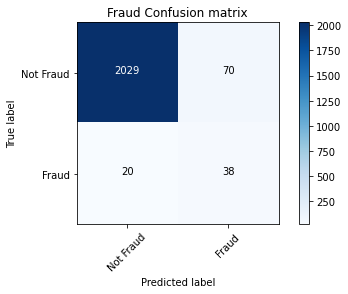

In [93]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

**Instructions 3/3**

If you were to decrease the percentile used as a cutoff point in the previous exercise to 93% instead of 95%, what would that do to your prediction results?

**Possible Answers**

* **The number of fraud cases caught increases, but false positives also increase.**
* ~~The number of fraud cases caught decreases, and false positives decrease.~~
* ~~The number of fraud cases caught increases, but false positives would decrease.~~
* ~~Nothing would happen to the amount of fraud cases caught.~~

### Fraud detection without labels

* Learned about the importance of segmentation
* Refreshed your knowledge on clustering methods
* Learned how to detect fraud using outliers and small clusters with K-means clustering